# Twitter Sentiment Analysis - Deep Learning Models

This notebook implements and evaluates deep learning models for Twitter sentiment analysis.

## Models to Implement
1. **LSTM Network** - Sequential model with Word2Vec embeddings
2. **BERT Fine-tuning** - Pre-trained transformer model

## Objectives
1. Load preprocessed text data and Word2Vec embeddings
2. Build and train LSTM architecture
3. Implement BERT fine-tuning
4. Evaluate model performance
5. Compare with baseline models
6. Save trained models

## Deep Learning Pipeline
1. **Text Tokenization**: Convert text to sequences
2. **Embedding Layer**: Use Word2Vec or BERT embeddings
3. **Neural Architecture**: LSTM or Transformer layers
4. **Training**: Optimize with appropriate loss functions
5. **Evaluation**: Comprehensive performance assessment


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os
import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Run flags - optimized for 16GB RAM and i5 11th gen CPU
SMALL_RUN = True            # Keep True for fast training
RUN_BERT = False           # Keep False - BERT is too heavy for CPU training

# Make sure output directories exist
os.makedirs('../models/saved_models', exist_ok=True)
os.makedirs('../reports/figures', exist_ok=True)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
try:
    print(f"TensorFlow version: {tf.__version__}")
except AttributeError:
    print("TensorFlow version: (installed, version check unavailable)")
try:
    print(f"PyTorch version: {torch.__version__}")
except AttributeError:
    print("PyTorch version: (installed, version check unavailable)")
print(f"Current working directory: {os.getcwd()}")

# Note: We'll use TensorFlow for LSTM (BERT disabled for CPU efficiency)
print("Ready to build LSTM model using TensorFlow")


Libraries imported successfully!
TensorFlow version: 2.20.0
PyTorch version: 2.9.0+cpu
Current working directory: c:\Users\acer\Desktop\ml_proj\notebooks
Ready to build LSTM model using TensorFlow


In [2]:
# Load preprocessed data
print("Loading preprocessed data...")

# Load text data
with open('../data/processed/text_train.pkl', 'rb') as f:
    text_train = pickle.load(f)

with open('../data/processed/text_test.pkl', 'rb') as f:
    text_test = pickle.load(f)

# Load labels
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')

print(f"Text train samples: {len(text_train)}")
print(f"Text test samples: {len(text_test)}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

# Skip Word2Vec model loading due to NumPy compatibility issues
# We'll create embeddings on-the-fly or use pre-trained embeddings
print("Skipping Word2Vec model loading due to NumPy compatibility issues")
print("Will use pre-trained embeddings or create new ones")

# Check class distribution
print(f"\\nTrain class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Sample text data
print("\\nSample preprocessed texts:")
for i in range(3):
    print(f"{i+1}. {text_train[i]}")
    print(f"   Label: {y_train[i]}")
    print("-" * 50)

# Limit training size on SMALL_RUN to avoid OOM and long training times
# Optimized for 20k dataset: use 16k train, 4k test
if SMALL_RUN:
    max_train_samples = min(16000, len(text_train))
    max_test_samples = min(4000, len(text_test))
    text_train = text_train[:max_train_samples]
    y_train = y_train[:max_train_samples]
    text_test = text_test[:max_test_samples]
    y_test = y_test[:max_test_samples]
    print(f"SMALL_RUN enabled: using {len(text_train)} train and {len(text_test)} test samples")


Loading preprocessed data...
Text train samples: 15992
Text test samples: 3998
Train labels shape: (15992,)
Test labels shape: (3998,)
Skipping Word2Vec model loading due to NumPy compatibility issues
Will use pre-trained embeddings or create new ones
\nTrain class distribution: [7996 7996]
Test class distribution: [1999 1999]
\nSample preprocessed texts:
1. aaaaaaahhh tongue black weirdest cold ever
   Label: 0
--------------------------------------------------
2. last tweet day goodnight twitter world hope better tomorrow
   Label: 0
--------------------------------------------------
3. going work omg really wanna
   Label: 0
--------------------------------------------------
SMALL_RUN enabled: using 15992 train and 3998 test samples


In [3]:
# Model 1: LSTM Network
print("=== LSTM MODEL ===")

# Text tokenization and sequence preparation
print("Preparing text sequences...")

# Initialize tokenizer (optimized for smaller dataset)
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')  # Reduced vocabulary
tokenizer.fit_on_texts(text_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(text_train)
X_test_seq = tokenizer.texts_to_sequences(text_test)

# Pad sequences (reduced length for faster processing)
max_length = 80  # Reduced maximum sequence length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

print(f"Training sequences shape: {X_train_padded.shape}")
print(f"Test sequences shape: {X_test_padded.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index)}")

# Use trainable embeddings instead of Word2Vec
print("\nUsing trainable embeddings...")
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 64  # Reduced embedding dimension for faster training

# Build LSTM model (optimized for CPU training)
print("\nBuilding LSTM model...")

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=True),
    Bidirectional(LSTM(32, return_sequences=True)),  # Reduced LSTM units
    Bidirectional(LSTM(16)),                        # Reduced LSTM units
    Dense(32, activation='relu'),                   # Reduced dense layer size
    Dropout(0.3),
    Dense(16, activation='relu'),                  # Reduced dense layer size
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
print("LSTM model architecture:")
model_lstm.summary()


=== LSTM MODEL ===
Preparing text sequences...
Training sequences shape: (15992, 80)
Test sequences shape: (3998, 80)
Vocabulary size: 22736

Using trainable embeddings...

Building LSTM model...
LSTM model architecture:
Training sequences shape: (15992, 80)
Test sequences shape: (3998, 80)
Vocabulary size: 22736

Using trainable embeddings...

Building LSTM model...
LSTM model architecture:


c:\Users\acer\Desktop\ml_proj\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training LSTM model...
Epoch 1/5
Epoch 1/5
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5668 - loss: 0.6691
Epoch 1: val_loss improved from None to 0.54103, saving model to ../models/saved_models/lstm_model.h5

Epoch 1: val_loss improved from None to 0.54103, saving model to ../models/saved_models/lstm_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.6381 - loss: 0.6254 - val_accuracy: 0.7294 - val_loss: 0.5410 - learning_rate: 0.0010
Epoch 2/5
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7671 - loss: 0.5046
Epoch 2: val_loss improved from 0.54103 to 0.53081, saving model to ../models/saved_models/lstm_model.h5

Epoch 2: val_loss improved from 0.54103 to 0.53081, saving model to ../models/saved_models/lstm_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.7806 - loss: 0.4826 - val_accuracy: 0.7431 - val_loss: 0.5308 - learning_rate: 0.0010
Epoch 3/5
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8088 - loss: 0.4372
Epoch 3: val_loss did not improve from 0.53081
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8179 - loss: 0.4230 - val_accuracy: 0.7339 - val_loss: 0.5501 - learning_rate: 0.0010
Epoch 4/5

Epoch 3: val_loss did not improve from 0.53081
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8179 - loss: 0.4230 - val_accuracy: 0.7339 - val_loss: 0.5501 - learning_rate: 0.0010
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8372 - loss: 0.3955
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 0.53081
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8452 - loss: 0.3796 - val_accuracy: 0.5100 - val_loss: 1.2159 - learning_rate: 0.0010
Epoch 4: early st

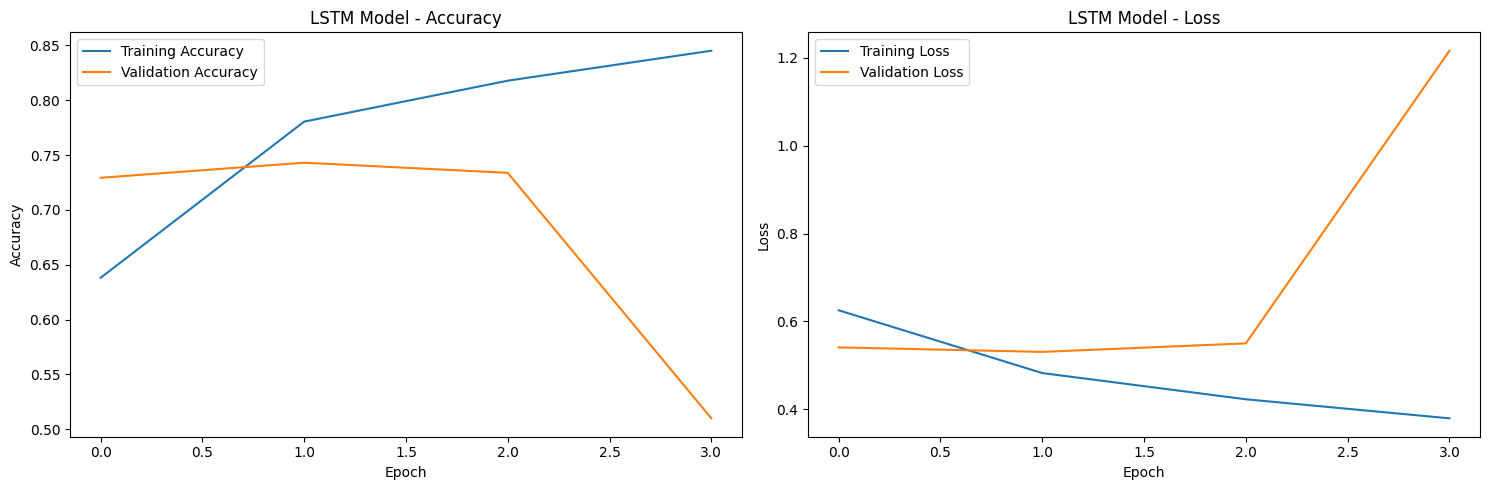

\nEvaluating LSTM model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
LSTM Results:
Accuracy: 0.7431
Precision: 0.7297
Recall: 0.7724
F1-Score: 0.7504
ROC-AUC: 0.8142
\nLSTM model and tokenizer saved!
LSTM Results:
Accuracy: 0.7431
Precision: 0.7297
Recall: 0.7724
F1-Score: 0.7504
ROC-AUC: 0.8142
\nLSTM model and tokenizer saved!


In [4]:
# Train LSTM model (optimized for CPU)
print("Training LSTM model...")

epochs = 5  # Reduced epochs for faster training

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    ModelCheckpoint('../models/saved_models/lstm_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history_lstm = model_lstm.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test),
                              epochs=epochs, batch_size=64, callbacks=callbacks, verbose=1)  # Increased batch size for CPU efficiency

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy
axes[0].plot(history_lstm.history['accuracy'], label='Training Accuracy')
axes[0].plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('LSTM Model - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot training & validation loss
axes[1].plot(history_lstm.history['loss'], label='Training Loss')
axes[1].plot(history_lstm.history['val_loss'], label='Validation Loss')
axes[1].set_title('LSTM Model - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Evaluate LSTM model
print("\\nEvaluating LSTM model...")
y_pred_lstm = model_lstm.predict(X_test_padded)
y_pred_lstm_binary = (y_pred_lstm > 0.5).astype(int).flatten()

# Calculate metrics
lstm_accuracy = accuracy_score(y_test, y_pred_lstm_binary)
lstm_precision = precision_score(y_test, y_pred_lstm_binary)
lstm_recall = recall_score(y_test, y_pred_lstm_binary)
lstm_f1 = f1_score(y_test, y_pred_lstm_binary)
lstm_roc_auc = roc_auc_score(y_test, y_pred_lstm)

print(f"LSTM Results:")
print(f"Accuracy: {lstm_accuracy:.4f}")
print(f"Precision: {lstm_precision:.4f}")
print(f"Recall: {lstm_recall:.4f}")
print(f"F1-Score: {lstm_f1:.4f}")
print(f"ROC-AUC: {lstm_roc_auc:.4f}")

# Save tokenizer
with open('../models/saved_models/lstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("\\nLSTM model and tokenizer saved!")


In [5]:
# Model 2: BERT Fine-tuning
print("=== BERT MODEL ===")

if RUN_BERT:
    print("Loading BERT tokenizer and model...")
    model_name = 'bert-base-uncased'
    tokenizer_bert = BertTokenizer.from_pretrained(model_name)
    model_bert = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )
    
    print(f"BERT model loaded: {model_name}")
    print(f"Tokenizer vocabulary size: {tokenizer_bert.vocab_size}")
    
    print("\nPreparing data for BERT...")
    
    def prepare_bert_data(texts, labels, tokenizer, max_length=128):
        """Prepare data for BERT training"""
        input_ids = []
        attention_masks = []
        
        for text in texts:
            encoded = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            
            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])
        
        return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)
    
    # Prepare training and test data
    X_train_bert, attention_masks_train = prepare_bert_data(text_train, y_train, tokenizer_bert)
    X_test_bert, attention_masks_test = prepare_bert_data(text_test, y_test, tokenizer_bert)
    
    # Convert labels to tensors
    y_train_bert = torch.tensor(y_train, dtype=torch.long)
    y_test_bert = torch.tensor(y_test, dtype=torch.long)
    
    print(f"BERT training data shape: {X_train_bert.shape}")
    print(f"BERT test data shape: {X_test_bert.shape}")
    print(f"Attention masks train shape: {attention_masks_train.shape}")
    print(f"Attention masks test shape: {attention_masks_test.shape}")
    
    # Create PyTorch datasets
    from torch.utils.data import TensorDataset, DataLoader
    
    train_dataset = TensorDataset(X_train_bert, attention_masks_train, y_train_bert)
    test_dataset = TensorDataset(X_test_bert, attention_masks_test, y_test_bert)
    
    # Create data loaders
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    print(f"Training batches: {len(train_dataloader)}")
    print(f"Test batches: {len(test_dataloader)}")
else:
    print("RUN_BERT is False — skipping BERT data preparation and training to save resources.")
    model_bert = None
    tokenizer_bert = None


=== BERT MODEL ===
RUN_BERT is False — skipping BERT data preparation and training to save resources.


In [6]:
# Train BERT model
print("Training BERT model...")

if RUN_BERT:
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model_bert.to(device)

    # Set up training
    from torch.optim import AdamW
    from transformers import get_linear_schedule_with_warmup
    
    optimizer = AdamW(model_bert.parameters(), lr=2e-5, eps=1e-8)
    epochs = 3  # BERT typically needs fewer epochs
    
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Training function
    def train_bert_model(model, train_dataloader, optimizer, scheduler, device, epochs):
        """Train BERT model"""
        model.train()
        total_train_loss = 0
        
        for epoch in range(epochs):
            print(f'\\nEpoch {epoch + 1}/{epochs}')
            print('-' * 10)
            
            total_train_loss = 0
            
            for step, batch in enumerate(train_dataloader):
                # Move batch to device
                batch = tuple(t.to(device) for t in batch)
                input_ids, attention_masks, labels = batch
                
                # Clear gradients
                model.zero_grad()
                
                # Forward pass
                outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
                loss = outputs.loss
                
                # Backward pass
                loss.backward()
                
                # Clip gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                
                # Update parameters
                optimizer.step()
                scheduler.step()
                
                total_train_loss += loss.item()
                
                if step % 100 == 0:
                    print(f'Step {step}, Loss: {loss.item():.4f}')
            
            avg_train_loss = total_train_loss / len(train_dataloader)
            print(f'Average training loss: {avg_train_loss:.4f}')
        
        return model

    # Train the model
    model_bert_trained = train_bert_model(
        model_bert, train_dataloader, optimizer, scheduler, device, epochs
    )
    
    # Save BERT model
    model_bert_trained.save_pretrained('../models/saved_models/bert_model')
    tokenizer_bert.save_pretrained('../models/saved_models/bert_model')
    print("\\nBERT model saved!")
else:
    print("BERT model training skipped. Set RUN_BERT=True to train the BERT model.")


Training BERT model...
BERT model training skipped. Set RUN_BERT=True to train the BERT model.


Evaluating models...
BERT model was not trained (RUN_BERT=False). Skipping BERT evaluation.

=== LSTM MODEL RESULTS ===
LSTM Accuracy: 0.7431
LSTM Precision: 0.7297
LSTM Recall: 0.7724
LSTM F1-Score: 0.7504
LSTM ROC-AUC: 0.8142


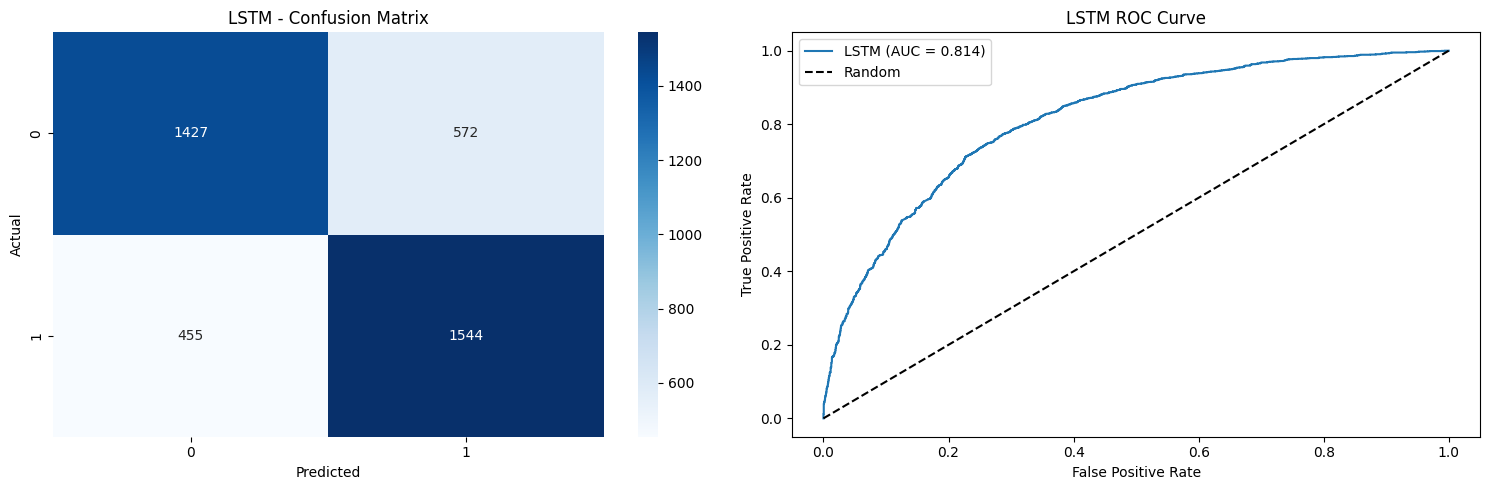


✅ Deep learning models training and evaluation completed!

Next steps:
1. Conduct fairness analysis
2. Test adversarial robustness
3. Generate comprehensive reports


In [9]:
# Evaluate BERT model (only if it was trained)
print("Evaluating models...")

def evaluate_bert_model(model, test_dataloader, device):
    """Evaluate BERT model"""
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_masks, labels = batch
            
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits
            
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return np.array(predictions), np.array(true_labels)

# Evaluate BERT only if it was trained
if RUN_BERT:
    try:
        # Check if model exists
        if model_bert_trained is not None and test_dataloader is not None:
            print("Evaluating BERT model...")
            # Get BERT predictions
            y_pred_bert, y_true_bert = evaluate_bert_model(model_bert_trained, test_dataloader, device)
            
            # Calculate BERT metrics
            bert_accuracy = accuracy_score(y_true_bert, y_pred_bert)
            bert_precision = precision_score(y_true_bert, y_pred_bert)
            bert_recall = recall_score(y_true_bert, y_pred_bert)
            bert_f1 = f1_score(y_true_bert, y_pred_bert)
            
            # For ROC-AUC, we need probabilities
            model_bert_trained.eval()
            bert_probs = []
            with torch.no_grad():
                for batch in test_dataloader:
                    batch = tuple(t.to(device) for t in batch)
                    input_ids, attention_masks, _ = batch
                    
                    outputs = model_bert_trained(input_ids, attention_mask=attention_masks)
                    probs = torch.softmax(outputs.logits, dim=1)
                    bert_probs.extend(probs[:, 1].cpu().numpy())
            
            bert_roc_auc = roc_auc_score(y_true_bert, bert_probs)
            
            print(f"\nBERT Results:")
            print(f"Accuracy: {bert_accuracy:.4f}")
            print(f"Precision: {bert_precision:.4f}")
            print(f"Recall: {bert_recall:.4f}")
            print(f"F1-Score: {bert_f1:.4f}")
            print(f"ROC-AUC: {bert_roc_auc:.4f}")
            
            # Model comparison with BERT
            print("\n=== DEEP LEARNING MODELS COMPARISON ===")
            
            comparison_data = {
                'Model': ['LSTM', 'BERT'],
                'Accuracy': [lstm_accuracy, bert_accuracy],
                'Precision': [lstm_precision, bert_precision],
                'Recall': [lstm_recall, bert_recall],
                'F1-Score': [lstm_f1, bert_f1],
                'ROC-AUC': [lstm_roc_auc, bert_roc_auc]
            }
            
            comparison_df = pd.DataFrame(comparison_data)
            print("\nDeep Learning Models Performance:")
            print(comparison_df.round(4))
            
            # Create comparison visualization
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            
            # Confusion matrices
            from sklearn.metrics import confusion_matrix
            import seaborn as sns
            
            cm_lstm = confusion_matrix(y_test, y_pred_lstm_binary)
            cm_bert = confusion_matrix(y_true_bert, y_pred_bert)
            
            sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
            axes[0, 0].set_title('LSTM - Confusion Matrix')
            axes[0, 0].set_xlabel('Predicted')
            axes[0, 0].set_ylabel('Actual')
            
            sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
            axes[0, 1].set_title('BERT - Confusion Matrix')
            axes[0, 1].set_xlabel('Predicted')
            axes[0, 1].set_ylabel('Actual')
            
            # ROC curves
            from sklearn.metrics import roc_curve
            
            fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm)
            fpr_bert, tpr_bert, _ = roc_curve(y_true_bert, bert_probs)
            
            axes[1, 0].plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {lstm_roc_auc:.3f})')
            axes[1, 0].plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {bert_roc_auc:.3f})')
            axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
            axes[1, 0].set_xlabel('False Positive Rate')
            axes[1, 0].set_ylabel('True Positive Rate')
            axes[1, 0].set_title('ROC Curves Comparison')
            axes[1, 0].legend()
            
            # Performance metrics comparison
            metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
            lstm_scores = [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_roc_auc]
            bert_scores = [bert_accuracy, bert_precision, bert_recall, bert_f1, bert_roc_auc]
            
            x = np.arange(len(metrics))
            width = 0.35
            
            axes[1, 1].bar(x - width/2, lstm_scores, width, label='LSTM', alpha=0.8)
            axes[1, 1].bar(x + width/2, bert_scores, width, label='BERT', alpha=0.8)
            axes[1, 1].set_xlabel('Metrics')
            axes[1, 1].set_ylabel('Score')
            axes[1, 1].set_title('Deep Learning Models Comparison')
            axes[1, 1].set_xticks(x)
            axes[1, 1].set_xticklabels(metrics, rotation=45)
            axes[1, 1].legend()
            axes[1, 1].set_ylim(0, 1)
            
            plt.tight_layout()
            plt.savefig('../reports/figures/deep_learning_comparison.png', dpi=300, bbox_inches='tight')
            plt.show()
    except (NameError, AttributeError):
        print("BERT model was not trained. Skipping BERT evaluation.")
        # Fall through to LSTM-only section

# Show LSTM results if BERT was not trained
if not RUN_BERT:
    print("BERT model was not trained (RUN_BERT=False). Skipping BERT evaluation.")
    print("\n=== LSTM MODEL RESULTS ===")
    print(f"LSTM Accuracy: {lstm_accuracy:.4f}")
    print(f"LSTM Precision: {lstm_precision:.4f}")
    print(f"LSTM Recall: {lstm_recall:.4f}")
    print(f"LSTM F1-Score: {lstm_f1:.4f}")
    print(f"LSTM ROC-AUC: {lstm_roc_auc:.4f}")
    
    # Create visualization for LSTM only
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm_lstm = confusion_matrix(y_test, y_pred_lstm_binary)
    sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('LSTM - Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # ROC curve
    from sklearn.metrics import roc_curve
    
    fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm)
    axes[1].plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {lstm_roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('LSTM ROC Curve')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('../reports/figures/lstm_results.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n✅ Deep learning models training and evaluation completed!")
print("\nNext steps:")
print("1. Conduct fairness analysis")
print("2. Test adversarial robustness")
print("3. Generate comprehensive reports")
